<a href="https://colab.research.google.com/github/thayeylolu/cyberbullying/blob/main/notebooks/hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download libraries need to pretain the transformer

- transformers: contains the transformer to use
- datasets: to preprocess that data as a Datset type
- evaluate : to calculate the accuracy metric 

### Import libraries

In [3]:
import torch, random
from google.colab import files
import numpy as np
import pandas as pd
import scikitplot as skplt
import time
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import os 
from transformers import AutoTokenizer
from sklearn import preprocessing
from transformers import TrainingArguments
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback


### Set random seed to ensure code reproducuiblity

In [4]:
np.random.seed(3040)
torch.manual_seed(3040)
random.seed(3040)


### Load data from google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')
url = "drive/MyDrive/NLP/train_data.csv"

Mounted at /content/drive


### Processing
- define a label encoder to transform `cyberbullying-type` to numbers
- import the csv
- drop nan values by the records
- drop `unnamed :0` column
- select only  `cyberbullying_type` and `clean_txt_emoji` columns


In [6]:
le = preprocessing.LabelEncoder()
df = pd.read_csv(url)
df = df.dropna()
df = df.drop(columns = ["Unnamed: 0"])
df = df[['cyberbullying_type', 'clean_txt_emoji']]



### get unique `cyberbullying_type` and convert to a list

In [7]:
label_names = list(df['cyberbullying_type'].unique())
label_names

['not_cyberbullying',
 'gender',
 'religion',
 'other_cyberbullying',
 'age',
 'ethnicity']

- Assign `cyberbullying_type` to a new column named `label`
- fit and transform `label` with defined label transformer
- Assign `cleN_text_emoji` to a new column named `text` 
- call random seeds
- split data into train, test and validate 


In [8]:
df['label'] = df['cyberbullying_type']
df['label'] = le.fit_transform(df['label'])
df['text'] = df['clean_txt_emoji']

np.random.seed(3040)
torch.manual_seed(3040)
random.seed(3040)

train, test_valid = train_test_split(df,train_size= 0.70, random_state= 3040)
test, valid = train_test_split(test_valid,train_size= .50, random_state= 3040)



- call random seeds
- conver the trian,text, validate dataset to a `DataSet` type and remove unneccesary columns
- use GPU to train if it is available, else use a cpu
- initialize a tokenizer `DistilBertTokenizer` that uses `uncased` tokenizer. This means the tokenizer is trained on lower case words.
- define a `tokenize_function` to tokenize the texts and pad them with the maximun length of words in the `text` column
- map the `tokenize_function` to the train and valid dataset
- define the pretrained model by setting the number of classes to the lenght of unique classes in `labels`
- define the evaluation metirc and set it to accuracy


In [9]:
np.random.seed(3040)
torch.manual_seed(3040)
random.seed(3040)


train_dataset = Dataset.from_pandas(train).remove_columns(["__index_level_0__",  'clean_txt_emoji'])
valid_dataset = Dataset.from_pandas(valid).remove_columns(["__index_level_0__",  'clean_txt_emoji'])
test_dataset = Dataset.from_pandas(test).remove_columns(["__index_level_0__", 'clean_txt_emoji'])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_valid = valid_dataset.map(tokenize_function, batched=True)

modelDistilBert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

metric = evaluate.load("accuracy")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

- set the random seeds
- define a function `compute_metric` that calculates the accuracy of the predictions. It first converts the predictions to logits, the returns the accuracy score
- create a `TrainingArguments` class which contains all the hyperparameters to can tune the training process.
- Create a Trainer object: `trainer` with deined model, training arguments, training and test datasets, and evaluation function.


In [19]:
np.random.seed(3040)
torch.manual_seed(3040)
random.seed(3040)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    report_to = "none",
    seed=3040,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=modelDistilBert,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid ,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


PyTorch: setting up devices


In [20]:
start_t = time.time()
trainer.train()
    # evaluate model
eval_result = trainer.evaluate(eval_dataset=test_dataset)

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, cyberbullying_type. If text, cyberbullying_type are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 33144
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12429
  Number of trainable parameters = 66958086


Step,Training Loss,Validation Loss,Accuracy
500,0.170000,1.034099,0.813318
1000,0.498000,0.432249,0.847388
1500,0.446200,0.415892,0.835281
2000,0.442300,0.379440,0.854428
2500,0.407000,0.379026,0.850626
3000,0.407300,0.380317,0.849782
3500,0.416800,0.357143,0.860059
4000,0.399300,0.362992,0.857525
4500,0.324700,0.416355,0.862734


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, cyberbullying_type. If text, cyberbullying_type are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7103
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, cyberbullying_type. If text, cyberbullying_type are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7103
  Batch size = 8
Saving model checkpoint to output/checkpoint-1000
Configuration saved i

Step,Training Loss,Validation Loss,Accuracy
500,0.170000,1.034099,0.813318
1000,0.498000,0.432249,0.847388
1500,0.446200,0.415892,0.835281
2000,0.442300,0.379440,0.854428
2500,0.407000,0.379026,0.850626
3000,0.407300,0.380317,0.849782
3500,0.416800,0.357143,0.860059
4000,0.399300,0.362992,0.857525
4500,0.324700,0.416355,0.862734
5000,0.329600,0.387987,0.858229


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, cyberbullying_type. If text, cyberbullying_type are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7103
  Batch size = 8
Saving model checkpoint to output/checkpoint-5000
Configuration saved in output/checkpoint-5000/config.json
Model weights saved in output/checkpoint-5000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-3500 (score: 0.35714277625083923).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, cyberbullying_type. If text, cyberbullying_type are not expected by `DistilBertForSequenceClassification.forward`,  you can saf

ValueError: ignored

## Save best model

- save best model in output folder
- calculate elasped time

In [21]:

use_model = trainer.save_model("output")
end_t = time.time()
elapsed_time = end_t - start_t
print('Time taken to Train the model:', elapsed_time, 'seconds')

Saving model checkpoint to output
Configuration saved in output/config.json
Model weights saved in output/pytorch_model.bin


Time taken to Train the model: 3265.444835662842 seconds


### Prediciton
- call the fine tuned model that was saved in `output` directory

In [22]:
fine_tuned_model = DistilBertForSequenceClassification.from_pretrained("output")

loading configuration file output/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading weights file output/pytorch_mode

### create a pipeline to pass the test data into

In [23]:
# next step: follow this:
#https://discuss.huggingface.co/t/predicting-on-new-text-with-fine-tuned-multi-label-model/13046

from transformers import pipeline
clf = pipeline("text-classification", tokenizer = tokenizer, model=fine_tuned_model)


### apply to all the test data

In [24]:
answer = test['text'].apply(lambda x: clf(x))
#answer

In [27]:
answer

9465     [{'label': 'LABEL_2', 'score': 0.9994859695434...
31886    [{'label': 'LABEL_0', 'score': 0.9933630228042...
10936    [{'label': 'LABEL_2', 'score': 0.9994781613349...
2611     [{'label': 'LABEL_2', 'score': 0.7660296559333...
46625    [{'label': 'LABEL_1', 'score': 0.9998281002044...
                               ...                        
42623    [{'label': 'LABEL_1', 'score': 0.9998207688331...
9757     [{'label': 'LABEL_2', 'score': 0.9991480112075...
40304    [{'label': 'LABEL_1', 'score': 0.9998310804367...
3853     [{'label': 'LABEL_4', 'score': 0.4782207608222...
44892    [{'label': 'LABEL_1', 'score': 0.9998182654380...
Name: text, Length: 7102, dtype: object

### Map function to convert the label names to the appropriate cyberbullying type

In [71]:

type_cyber = ['age', 'ethnicity', 'gender', 'not_cyberbullying', 'other_cyberbullying', 'religion']
label_name = ["LABEL_0",'LABEL_1', 'LABEL_2', 'LABEL_3', 'LABEL_4', 'LABEL_5']

def replace_label_name(x):
  for  cyber_bullying_type,label  in zip(type_cyber, label_name):
    if x[0]['label']== label:
      return cyber_bullying_type

test['hugging_face_labels'] = test['hugging_face'].apply(lambda x:replace_label_name(x))


In [74]:
test.sample(10)


,cyberbullying_type,clean_txt_emoji,label,text,hugging_face,hugging_face_labels
31456,other_cyberbullying,just few minutes until this panel starts zoe g...,4,just few minutes until this panel starts zoe g...,"[{'label': 'LABEL_4', 'score': 0.6729049682617...",other_cyberbullying
8346,gender,just going stick old gamer nose here and say t...,2,just going stick old gamer nose here and say t...,"[{'label': 'LABEL_2', 'score': 0.9993365406990...",gender
31364,other_cyberbullying,are you seriously telling that want fix the in...,4,are you seriously telling that want fix the in...,"[{'label': 'LABEL_4', 'score': 0.6958025693893...",other_cyberbullying
35782,age,wish never graduated could high school bully,0,wish never graduated could high school bully,"[{'label': 'LABEL_0', 'score': 0.9993354678153...",age
1693,not_cyberbullying,someone today said that pete evans has never b...,3,someone today said that pete evans has never b...,"[{'label': 'LABEL_3', 'score': 0.9116458892822...",not_cyberbullying
43510,ethnicity,justify shut the fuck you got come back you du...,1,justify shut the fuck you got come back you du...,"[{'label': 'LABEL_1', 'score': 0.9998296499252...",ethnicity
30329,other_cyberbullying,got few questions how much actually bring with...,4,got few questions how much actually bring with...,"[{'label': 'LABEL_4', 'score': 0.6903165578842...",other_cyberbullying
14843,gender,not sexist but why girls talk football put you...,2,not sexist but why girls talk football put you...,"[{'label': 'LABEL_2', 'score': 0.9995236396789...",gender
32924,age,also fact remember high school where distanced...,0,also fact remember high school where distanced...,"[{'label': 'LABEL_0', 'score': 0.9995321035385...",age
9237,gender,stop raping boys stop raping girls stop making...,2,stop raping boys stop raping girls stop making...,"[{'label': 'LABEL_2', 'score': 0.9995160102844...",gender


### Calculate the Accuracy Score

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(test['cyberbullying_type'], test['hugging_face_labels'])

0.8493382145874402

In [77]:
accuracy_score(test['cyberbullying_type'], test['hugging_face_labels'])

0.8493382145874402

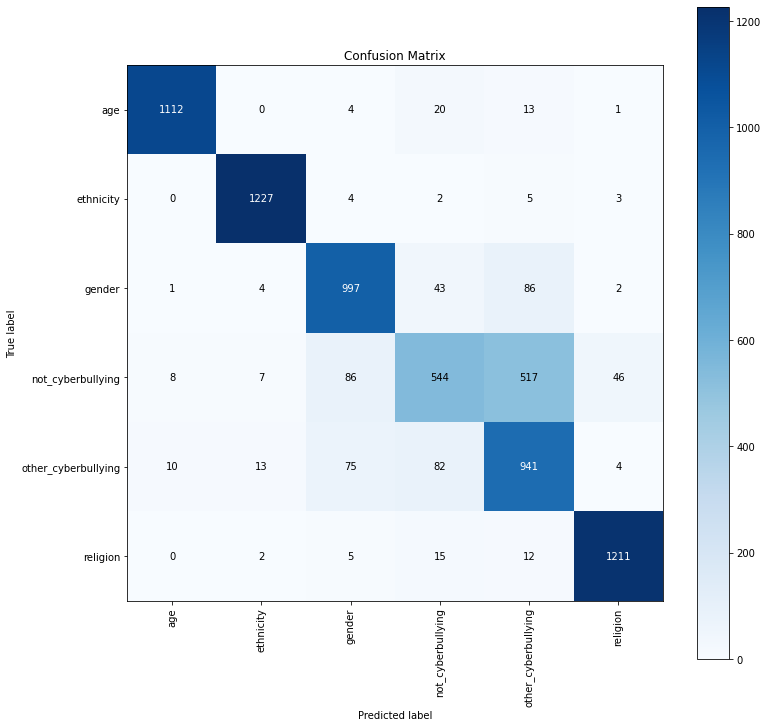

In [79]:

y_true = test['cyberbullying_type']
y_pred = test['hugging_face_labels']
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)